# LangGraph - Eine Einführung

Bis jetzt haben wir uns mit einem einzigen Agenten zufrieden gegeben. Aber wir können die Power der Agenten multiplizieren, wenn wir uns ein Agentensystem bauen!
Stell dir vor, du hast ein System, in dem für jede Aufgabe ein spezialisierter Agent zuständig ist. Komplexe Aufgaben werden z.B. durch einen Planer-Agent in Teilaufgaben heruntergebrochen und auf andere spezialisierte Agenten verteilt. Ein Koordinator kümmert sich um die Zusammenarbeit und trägt die Einzelergebnisse zusammen.

Das ist meines Erachtens die Zukunft. Stand heute Mitte 2024 gibt es diese Systeme schon, wenn auch nicht immer perfekt funktionierend. Aber die Entwicklung geht rasant voran und ich bin überzeugt, dass wir bald sehr gute Agentensysteme haben werden.

Aber so ein System ist komplex und es wäre sicher nicht sinnvoll das alles selber programmieren zu wollen. Deswegen möchten wir LangGraph kennenlernen und nutzen.

## Was ist LangGraph?

Laut der Beschreibung von den LangGraph-Machern selbst: 
> "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. "

Also handelt es sich um eine Bibliothek mit der wir Multi-Agenten Systeme (Agent Swarm) und Workflows bauen können! Mehr Details hier: https://langchain-ai.github.io/langgraph/

Was ist der Unterschied zu anderen Agenten-Frameworks wie AutoGen und Co.? LangGraph ist viel mehr Low-Level, d.h. man hat wesentlich mehr Kontrolle darüber, was und wie ausgeführt wird. Die anderen Frameworks hingegen verstecken die Logik. Oft definiert man dort, welche Agenten es gibt und welche Rollen sie haben. Die Art und Weise, wie sie interagieren etc. ist praktisch eine Blackbox.
Nachteil: LangGraph ist schwerer zu lernen.

Wir werden auch gleich sehen, dass die Programmierung eines Agentensystems auf Basis von LangGraph viel mit der Definition eines Workflowsystems zu tun hat.
Das Prinzip ist, dass KI (LLM ) dazu verwendet wird Entscheidungen zu treffen und Aktionen auszuführen, basierend auf dem Kontext.

Ein paar Zeilen Code sagen mehr als tausend Worte (berühmtes Zitat von S. Grünheit)... 

Wir wollen erstmal LangGraph ohne KI mal anschauen... einfach um das Gefühl zu bekommen, wie es tickt... Aber erstmal müssen wir LangGraph installieren.

In [1]:
!pip install langgraph langchain_openai


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


Jetzt bauen wir uns einen kleinen Graph. Dieser Graph macht zwar nichts besonders sinnvolles, aber er zeigt die Grundstruktur!

In [10]:
from langgraph.graph import MessageGraph, START, END
from langchain_core.messages import HumanMessage

# Wir erstellen einen MessageGraph. Das ist ein Graph, dessen "State" aus Messages besteht
graph = MessageGraph()

def modify_message(input: list[HumanMessage]):
    input[-1].content = input[-1].content + " - wurde geändert"
    return input

# Wir fügen zwei Nodes hinzu, die die Nachrichten verändern
graph.add_node("Node A", modify_message)
graph.add_node("Node B", modify_message)

graph.add_edge(START, "Node A")
graph.add_edge("Node A", "Node B")
graph.add_edge("Node B", END)

runnable = graph.compile()

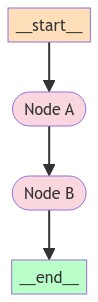

In [11]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [12]:
runnable.invoke([HumanMessage("Hallo Welt!")])

[HumanMessage(content='Hallo Welt! - wurde geändert - wurde geändert', id='9327ba67-0603-4300-88c6-fe1b1a6388a0')]

## Die Grundbausteine

LangGraph kennt drei wesentliche Grundbausteine: Node, Edges und State. Schauen wir uns diese mal genauer an.

### Node
Eine Funktion (Runnable) die den State ändert und zurück gibt. Ein Node bekommt einen State als Input und entscheidet anhand des State was zu tun ist und führt es ggfs. aus. Anschliessend wird der State geändert und zurückgeben. 

### Edge
Edges verbinden die Nodes. Es gibt Conditional-Edges die einen Kontrollfluss erlauben.

### State
State beinhaltet die Daten, die von den Nodes angepasst und zurückgegeben werden.

Wir haben jetzt die Grundbausteine kennengelernt, also lass uns jetzt etwas sinnvolles machen: lasst uns das Hallo-Welt der KIs bauen: einen Chatbot!

In [ ]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

model = ChatOpenAI(model="gpt-4o")

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}


# Das erste Argument ist der Name des Knotens.
# Das zweite Argument ist die Funktion, die aufgerufen wird, wenn
# der Knoten erreicht wird.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

In [ ]:
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Tschüss!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Agent:", value["messages"][-1].content)

Ok zugegeben, das war eine Menge Code für einen Chatbot!

Aber es zeigt zumindest einigermaßen, wie LangGraph tickt. Wir haben also offensichtlich einen Grafen, wo die Knoten Agentenfunktionen abbilden.